In [9]:
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time

In [11]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):

        self.observation_space = spaces.Discrete(9)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [2, 2]
        self.state = np.zeros((3,3))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5

        
    def reset(self, **kwargs):

        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()

        info = {}

        return observation, info
    
    def step(self, action):

        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
          self.agent_pos[0] -= 1
        if action == 2:
          self.agent_pos[1] += 1
        if action == 3:
          self.agent_pos[1] -= 1

        # Comment this to demonstrate the truncation condition.
        self.agent_pos = np.clip(self.agent_pos, 0, 2)

        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        
        reward = 0
        if np.array_equal(self.agent_pos, self.goal_pos):
          reward = 1
        
        self.timestep += 1

        terminated = True if self.timestep >= self.max_timesteps else False
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 2)) else False

        info = {}
        
        return observation, reward, terminated, truncated, info
        
    def render(self):
        plt.imshow(self.state)

In [12]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    return np.random.choice(self.action_space.n)

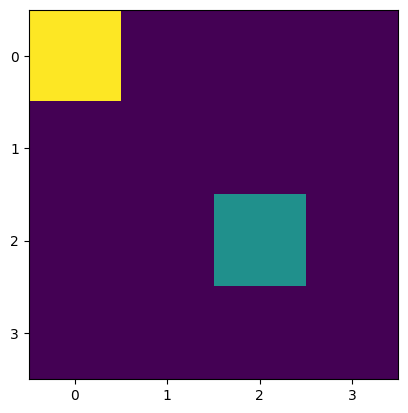

In [26]:
env = GridEnvironment()
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False

output_grid = plt.grid(which = "minor")
plt.xticks([0,1,2,3])
plt.yticks([0,1,2,3])
env.render()
